In [64]:
from pymrm import construct_convflux_upwind, construct_div, numjac_local, newton
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import eye_array

class CounterCurrent:
    def __init__(self, num_z=100):
        self.Ug = 1.0
        self.Ul = 1.0
        cg_in = 0.0
        cl_in = 1.0
        self.m = 20.0
        self.ka = 10.0 
        self.L = 1.0
        self.num_c = 1
        self.num_p = 2
        self.num_z = num_z
        self.bc = {'a': [[[[0],[1]]], [[[1],[0]]]], 'b': [[[[1],[0]]], [[[0],[1]]]], 'd': [[[[cg_in],[0]]], [[[0],[cl_in]]]]}
        self.x_f = np.linspace(0,self.L,self.num_z+1)
        self.x_c = 0.5*(self.x_f[0:-1]+self.x_f[1:])
        self.init_field()
        self.init_Jac()

    def mass_transfer(self, c):
        f = np.zeros_like(c)
        r = self.ka*(c[:, 0, :] / self.m - c[:, 1,:])
        f[:, 0, :] = -r
        f[:, 1, :] = r
        return f
            
    def init_field(self, c0=0.0):
        self.c = np.full((self.num_z, self.num_p, self.num_c),c0, dtype='float')

    def init_Jac(self):
        Conv, conv_bc = construct_convflux_upwind(self.c.shape, self.x_f, self.x_c, self.bc, v=[[[self.Ug],[-self.Ul]]] , axis=0)
        Div = construct_div(self.c.shape, self.x_f, axis=0)        
        Jac_conv = Div @ Conv
        f_conv_bc = Div @ conv_bc
        g_mt, Jac_mt = numjac_local(self.mass_transfer, self.c, axis=1)
        self.g_const = f_conv_bc
        self.Jac_const = Jac_conv - Jac_mt
        
    def construct_Jac(self, c):
        g = self.g_const + self.Jac_const @ c.reshape((-1,1))
        Jac = self.Jac_const
        return g,Jac
        
    def solve(self):
        result = newton(self.construct_Jac, self.c, maxfev=10)
        self.c = result.x
        plt.plot(self.x_c, self.c[:, 0], label='Component in gas')
        plt.plot(self.x_c, self.c[:, 1], label='Component in liquid')
        plt.xlabel('Position')
        plt.ylabel('Concentration')
        plt.legend()
        plt.show()

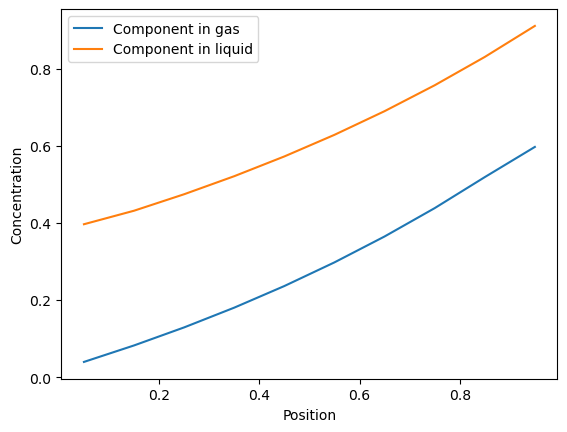

In [63]:
mrm_problem = CounterCurrent(10)
mrm_problem.solve()